# Scraping static webpages

Jaime Lopez  
jailop AT protonmail DOT com  
Mar. 2020

A lot of websites have valluable information, but gaining access to it for analytic purposes can be hard. In that cases is when you need to scrap a website to get the data from it. In this notebook, it is shown an example on scraping a static website. It must be observed to respect rights about the information, for example citing correctly the source when you make use of it.

In [1]:
import requests
from lxml import html
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact

## Product price index: how much are farmers making?

**Product Price Index** is website maitained by Western Growers Association. It contains an historical table of prices reported for farmers and retailers about agricultural products. The purpose of the site is shown how much money are really farmers making when they sell their products to retailers.

![shootscreen](images/productpriceindex.png)

Despite the value of this information, the problem is that it can only reviewed in the website. That condition restrains posibilities to analyze the data.

## URL structure

[productpriceindex.com](http://www.producepriceindex.com/) can be browsed changing the page number in the next link. Visually, navigation is made using a page selector in the bottom of each page.

![pageselector](images/productpriceindex_nav.png)

In [2]:
url = "http://www.producepriceindex.com/produce-price-index?page={}"

## Page scraper

The scraper look for each record. In the HTML source, it can be seem that records are contained in a table.

![records](images/productpriceindex_rec_html.png)

In [3]:
def scrap(page, first=False, sep=','):
    ret = ''
    if first:
        headers = [el.strip() for el in page.xpath("//thead/tr/th/text()")]
        ret += sep.join(headers) + "\n"
        first = False
    rows = page.xpath("//tbody/tr")
    for row in rows:
        cells = [
            re.sub("\$|\%|,", "", el.text_content().strip())
            for el in row.xpath("./td")
        ]
        ret += sep.join(cells) + "\n"
    return ret

## Page crawler

The first step to build our scraper is defining a function to navigate among all pages.

In [4]:
def crawler():
    """
    Param:
        funcproc : A function to process content
                   for each downloaded page
    """
    i = 0  # Starting page
    ret = ''
    while True:
        # Obtaining current page
        text = requests.get(url.format(i)).text
        page = html.fromstring(text)
        ret += scrap(page, first = True if i == 0 else False)
        # Looking for next page
        if i > 0:
            go = page.xpath("//ul[@class='pagination']/li/a/@title")
            look = [el for el in go if el.find(f" {i}") > 0]
            if len(look) == 0:
                break
        print('Page %d\r' % i, end='')
        i += 1
    return ret

The key point in previous code is the xpath sentence, which is infered reviewing the HTML source in the website.

![navbarhtml](images/productpriceindex_nav_html.png)

## Testing the scraper

In this section the scraper is tested. Results are stored in a temporal CSV file. This section can take a long time running.

In [5]:
with open('data/productpriceindex.csv', 'w') as fd:
    fd.write(crawler())

## Playing with the data

Data has been downloaded. It is ready to be consumed by an analytical procedure.

In [3]:
data = pd.read_csv('data/productpriceindex.csv')
data.head()

,Commodity,Record Date,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,New York Retail,Average Spread
0,Strawberries,2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33
1,Romaine Lettuce,2019-05-19,0.35,1.72,2.00,1.69,1.99,428.57
2,Red Leaf Lettuce,2019-05-19,0.32,1.84,1.84,1.69,1.89,467.19
3,Potatoes,2019-05-19,1.50,5.32,5.14,3.99,6.22,244.50
4,Oranges,2019-05-19,0.41,1.42,1.45,1.34,2.05,281.71


In [4]:
# Using Record Date as index
data.set_index(pd.to_datetime(data['Record Date'].values), inplace=True)
data.head()

,Commodity,Record Date,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,New York Retail,Average Spread
2019-05-19,Strawberries,2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33
2019-05-19,Romaine Lettuce,2019-05-19,0.35,1.72,2.00,1.69,1.99,428.57
2019-05-19,Red Leaf Lettuce,2019-05-19,0.32,1.84,1.84,1.69,1.89,467.19
2019-05-19,Potatoes,2019-05-19,1.50,5.32,5.14,3.99,6.22,244.50
2019-05-19,Oranges,2019-05-19,0.41,1.42,1.45,1.34,2.05,281.71


In [5]:
# Time series for Strawberries
def maketimeserieplot(commodity):
    plt.figure(figsize=(16, 9))
    subset = data[data['Commodity'] == commodity]
    for i in range(2, 7):
        column = subset.columns[i]
        if i == 2:
            plt.plot(subset.index, subset[column], label=column)
        else:
            plt.plot(subset.index, subset[column], label=column, linewidth=0.2)
    plt.legend()
    plt.ylabel('Price (USD)')

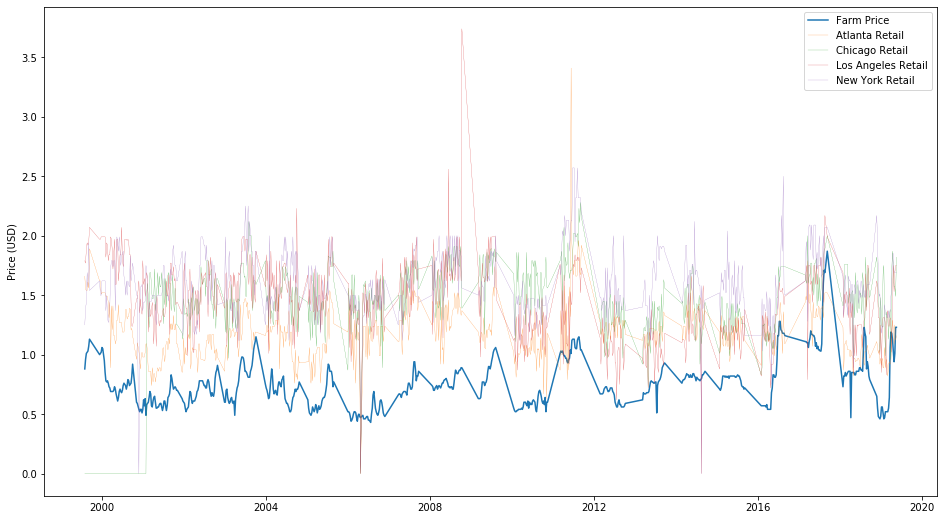

In [9]:
maketimeserieplot('Avocados')

In [7]:
labels = data.Commodity.sort_values().unique()
pack = [(label, i) for i, label in enumerate(labels)]

def control(n):
    maketimeserieplot(labels[n])

interact(control, n=widgets.Dropdown(options=pack, value=0, description='Commodity'))

interactive(children=(Dropdown(description='Commodity', options=(('Asparagus', 0), ('Avocados', 1), ('Broccoli…

<function __main__.control(n)>